In [ ]:
!pip install git+https://github.com/openai/CLIP.git
!pip install torch torchvision

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ukki6c54
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ukki6c54
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [ ]:
import scipy.io
import h5py
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import clip
import matplotlib.pyplot as plt
from IPython.display import HTML
import time
from PIL import Image
from google.colab import drive
import os
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATASET_PATH = '/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark' # TODO: Change this directory.

In [ ]:
# import matplotlib.pyplot as plt
# from IPython.display import display

def load_mat_file(file_path):
    """Load a MAT file and return its contents"""
    try:
        return scipy.io.loadmat(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

class CLIPDataset(Dataset):
    def __init__(self, anno_mat_path, image_h5_path, transform=None):
        self.model, self.preprocess = clip.load("ViT-B/32")

        if transform is None:
            self.transform = self.preprocess
        else:
            self.transform = transform

        self.file_path = image_h5_path
        self.anno_mat_path = anno_mat_path
        anno_data = load_mat_file(self.anno_mat_path)
        self.images = None

        self.texts = anno_data.get('engJ', None)
        if self.texts is None:
            raise ValueError("No 'engJ' found in .mat file.")

        self.original_texts = [text[0] for text in self.texts]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx][0][0]

        if self.images is None:
            self.images = h5py.File(self.file_path, 'r')["ih"]

        raw_image = self.images[idx]

        has_negative = np.any(raw_image < 0)
        min_value = raw_image.min()
        max_value = raw_image.max()

        if raw_image.shape[0] == 3:
            raw_image = np.transpose(raw_image, (2, 1, 0))

        if has_negative or max_value > 1.0:
            normalized_image = (raw_image - min_value) / (max_value - min_value)
            raw_image = (normalized_image * 255).astype(np.uint8)
        elif raw_image.dtype == np.float32 and max_value <= 1.0:
            raw_image = (raw_image * 255).astype(np.uint8)

        if raw_image.dtype != np.uint8:
            raw_image = raw_image.astype(np.uint8)


        pil_image = Image.fromarray(raw_image)

        transformed_image = self.transform(pil_image)

        return transformed_image, text, idx


In [ ]:
!nproc

12


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import clip


def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

anno_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Anno/language_original.mat"
g2_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Img/G2.h5"

dataset = CLIPDataset(anno_mat_path=anno_path, image_h5_path=g2_path, transform=None)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=12)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model, _ = clip.load("ViT-B/32", device=device)

save_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/finetuned_clip.pt"

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

epochs = 10
train_losses = []
best_loss = float('inf')

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    batch_count = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch_idx, (images, texts, _) in enumerate(progress_bar):
        optimizer.zero_grad()

        images = images.to(device)
        text_tokens = clip.tokenize(texts).to(device)

        logits_per_image, logits_per_text = model(images, text_tokens)
        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)

        batch_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        batch_loss.backward()

        if device == "cpu":
            optimizer.step()
        else:
            convert_models_to_fp32(model)
            optimizer.step()
            clip.model.convert_weights(model)

        epoch_loss += batch_loss.item()
        batch_count += 1

        progress_bar.set_postfix({"batch_loss": f"{batch_loss.item():.4f}", "avg_loss": f"{epoch_loss/batch_count:.4f}"})

    avg_epoch_loss = epoch_loss / batch_count
    train_losses.append(avg_epoch_loss)

    print(f"Epoch {epoch+1}/{epochs} completed. Average loss: {avg_epoch_loss:.4f}")

    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        torch.save(model.state_dict(), save_path)
        print(f"New best model saved with loss: {best_loss:.4f}")

print("Training complete!")

# Base Clip Performance


Evaluating on 5000 random samples...


Processing batches:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating similarity matrix on GPU...
Calculating ranks on GPU...

Fine-tuned CLIP Model Evaluation Results (on random subset):

Image-to-Text Retrieval:
R@1: 1.60%
R@5: 6.10%
R@10: 10.32%
Mean Rank: 365.99
Median Rank: 145.00

Text-to-Image Retrieval:
R@1: 1.90%
R@5: 6.86%
R@10: 11.42%
Mean Rank: 400.98
Median Rank: 143.00

Average Similarity Score for Matching Pairs: 0.2634


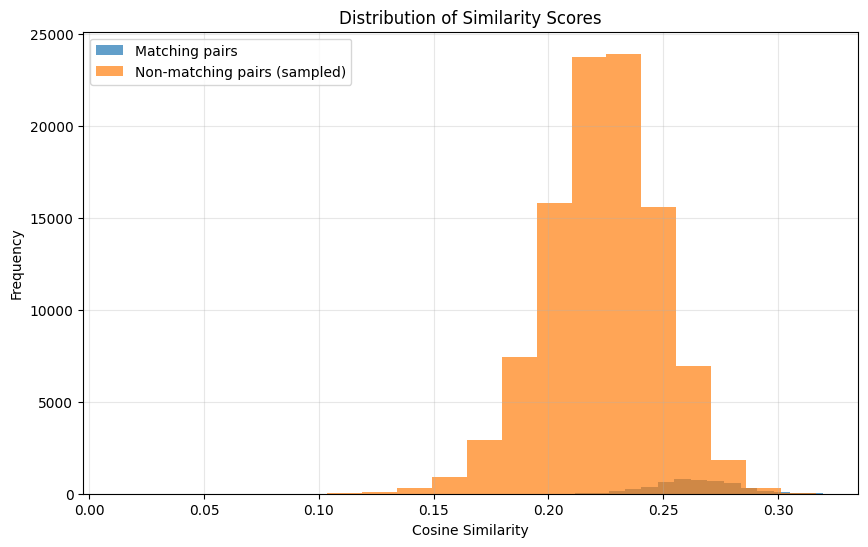

In [ ]:
import torch
import clip
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random

anno_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Anno/language_original.mat"
g2_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Img/G2.h5"

device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device)

model.eval()

test_dataset = CLIPDataset(anno_mat_path=anno_path, image_h5_path=g2_path, transform=None)

num_samples = 5000
random_indices = random.sample(range(len(test_dataset)), num_samples)

batch_size = 128
num_batches = (num_samples + batch_size - 1) // batch_size

all_image_features = []
all_text_features = []
all_texts = []

print(f"Evaluating on {num_samples} random samples...")

with torch.no_grad():
    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_indices = random_indices[start_idx:end_idx]

        batch_images = []
        batch_texts = []

        for idx in batch_indices:
            img, text, _ = test_dataset[idx]
            batch_images.append(img)
            batch_texts.append(text)

        images = torch.stack(batch_images).to(device)
        text_tokens = clip.tokenize(batch_texts).to(device)

        image_features = model.encode_image(images)
        text_features = model.encode_text(text_tokens)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        all_image_features.append(image_features)
        all_text_features.append(text_features)
        all_texts.extend(batch_texts)

all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)

print("Calculating similarity matrix on GPU...")
similarity = torch.matmul(all_image_features, all_text_features.T)

ground_truth = torch.arange(len(all_image_features), device=device)

print("Calculating ranks on GPU...")
_, i2t_sorted_indices = similarity.sort(dim=1, descending=True)
i2t_ranks = torch.where(i2t_sorted_indices == ground_truth.unsqueeze(1))[1]

_, t2i_sorted_indices = similarity.sort(dim=0, descending=True)
t2i_ranks = torch.where(t2i_sorted_indices == ground_truth.unsqueeze(0))[0]

i2t_r1 = (i2t_ranks < 1).float().mean() * 100
i2t_r5 = (i2t_ranks < 5).float().mean() * 100
i2t_r10 = (i2t_ranks < 10).float().mean() * 100

t2i_r1 = (t2i_ranks < 1).float().mean() * 100
t2i_r5 = (t2i_ranks < 5).float().mean() * 100
t2i_r10 = (t2i_ranks < 10).float().mean() * 100

mean_i2t_rank = i2t_ranks.float().mean() + 1
mean_t2i_rank = t2i_ranks.float().mean() + 1

median_i2t_rank = i2t_ranks.float().median() + 1
median_t2i_rank = t2i_ranks.float().median() + 1

avg_similarity = torch.diag(similarity).mean()

recall = {
    'image_to_text': {
        'R@1': i2t_r1.item(),
        'R@5': i2t_r5.item(),
        'R@10': i2t_r10.item(),
    },
    'text_to_image': {
        'R@1': t2i_r1.item(),
        'R@5': t2i_r5.item(),
        'R@10': t2i_r10.item(),
    }
}

print("\nFine-tuned CLIP Model Evaluation Results (on random subset):")
print("\nImage-to-Text Retrieval:")
print(f"R@1: {recall['image_to_text']['R@1']:.2f}%")
print(f"R@5: {recall['image_to_text']['R@5']:.2f}%")
print(f"R@10: {recall['image_to_text']['R@10']:.2f}%")
print(f"Mean Rank: {mean_i2t_rank.item():.2f}")
print(f"Median Rank: {median_i2t_rank.item():.2f}")

print("\nText-to-Image Retrieval:")
print(f"R@1: {recall['text_to_image']['R@1']:.2f}%")
print(f"R@5: {recall['text_to_image']['R@5']:.2f}%")
print(f"R@10: {recall['text_to_image']['R@10']:.2f}%")
print(f"Mean Rank: {mean_t2i_rank.item():.2f}")
print(f"Median Rank: {median_t2i_rank.item():.2f}")

print(f"\nAverage Similarity Score for Matching Pairs: {avg_similarity.item():.4f}")

plt.figure(figsize=(10, 6))
diag_sim = torch.diag(similarity).cpu().numpy()
mask = ~torch.eye(similarity.shape[0], dtype=bool, device=device)
nondiag_sim = similarity[mask].cpu()
if len(nondiag_sim) > 100000:
    nondiag_sim = nondiag_sim[torch.randperm(len(nondiag_sim))[:100000]]
nondiag_sim = nondiag_sim.numpy()

plt.hist(diag_sim, bins=20, alpha=0.7, label='Matching pairs')
plt.hist(nondiag_sim, bins=20, alpha=0.7, label='Non-matching pairs (sampled)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Finetuned Clip Performance

Evaluating on 5000 random samples...


Processing batches:   0%|          | 0/40 [00:00<?, ?it/s]

Calculating similarity matrix on GPU...
Calculating ranks on GPU...

Fine-tuned CLIP Model Evaluation Results (on random subset):

Image-to-Text Retrieval:
R@1: 0.24%
R@5: 1.30%
R@10: 2.44%
Mean Rank: 835.86
Median Rank: 502.00

Text-to-Image Retrieval:
R@1: 0.38%
R@5: 1.52%
R@10: 3.08%
Mean Rank: 832.64
Median Rank: 454.00

Average Similarity Score for Matching Pairs: 0.2091


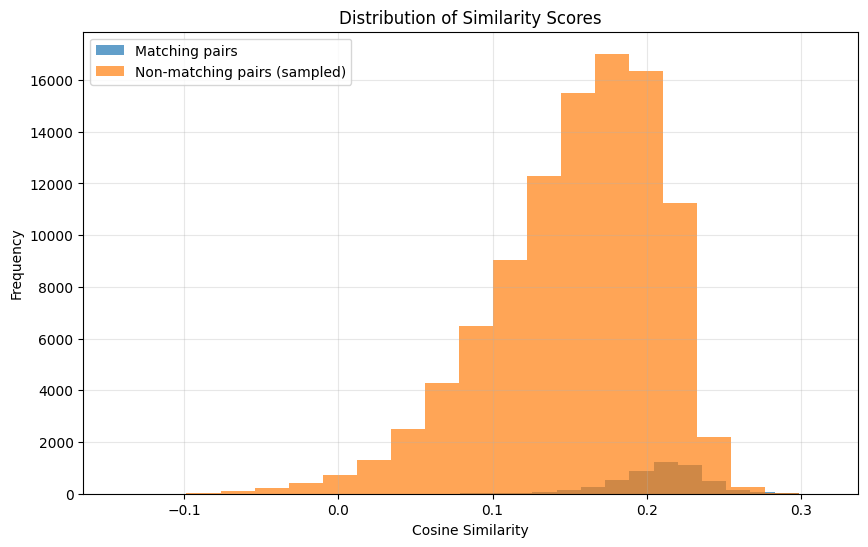

In [ ]:
import torch
import clip
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random



anno_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Anno/language_original.mat"
g2_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/Fashion Synthesis Benchmark/Img/G2.h5"
model_path = "/content/drive/MyDrive/Georgia Tech/25S/cs7643/Project/finetuned_clip.pt"

device = "cuda"
model, preprocess = clip.load("ViT-B/32", device=device)

# Load the fine-tuned weights
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

test_dataset = CLIPDataset(anno_mat_path=anno_path, image_h5_path=g2_path, transform=None)

num_samples = 5000
random_indices = random.sample(range(len(test_dataset)), num_samples)

batch_size = 128
num_batches = (num_samples + batch_size - 1) // batch_size

all_image_features = []
all_text_features = []
all_texts = []

print(f"Evaluating on {num_samples} random samples...")

with torch.no_grad():
    for i in tqdm(range(num_batches), desc="Processing batches"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_indices = random_indices[start_idx:end_idx]

        batch_images = []
        batch_texts = []

        for idx in batch_indices:
            img, text, _ = test_dataset[idx]
            batch_images.append(img)
            batch_texts.append(text)

        images = torch.stack(batch_images).to(device)
        text_tokens = clip.tokenize(batch_texts).to(device)

        image_features = model.encode_image(images)
        text_features = model.encode_text(text_tokens)

        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        all_image_features.append(image_features)
        all_text_features.append(text_features)
        all_texts.extend(batch_texts)

all_image_features = torch.cat(all_image_features, dim=0)
all_text_features = torch.cat(all_text_features, dim=0)

print("Calculating similarity matrix on GPU...")
similarity = torch.matmul(all_image_features, all_text_features.T)

ground_truth = torch.arange(len(all_image_features), device=device)

print("Calculating ranks on GPU...")
_, i2t_sorted_indices = similarity.sort(dim=1, descending=True)
i2t_ranks = torch.where(i2t_sorted_indices == ground_truth.unsqueeze(1))[1]

_, t2i_sorted_indices = similarity.sort(dim=0, descending=True)
t2i_ranks = torch.where(t2i_sorted_indices == ground_truth.unsqueeze(0))[0]

i2t_r1 = (i2t_ranks < 1).float().mean() * 100
i2t_r5 = (i2t_ranks < 5).float().mean() * 100
i2t_r10 = (i2t_ranks < 10).float().mean() * 100

t2i_r1 = (t2i_ranks < 1).float().mean() * 100
t2i_r5 = (t2i_ranks < 5).float().mean() * 100
t2i_r10 = (t2i_ranks < 10).float().mean() * 100

mean_i2t_rank = i2t_ranks.float().mean() + 1
mean_t2i_rank = t2i_ranks.float().mean() + 1

median_i2t_rank = i2t_ranks.float().median() + 1
median_t2i_rank = t2i_ranks.float().median() + 1

avg_similarity = torch.diag(similarity).mean()

recall = {
    'image_to_text': {
        'R@1': i2t_r1.item(),
        'R@5': i2t_r5.item(),
        'R@10': i2t_r10.item(),
    },
    'text_to_image': {
        'R@1': t2i_r1.item(),
        'R@5': t2i_r5.item(),
        'R@10': t2i_r10.item(),
    }
}

print("\nFine-tuned CLIP Model Evaluation Results (on random subset):")
print("\nImage-to-Text Retrieval:")
print(f"R@1: {recall['image_to_text']['R@1']:.2f}%")
print(f"R@5: {recall['image_to_text']['R@5']:.2f}%")
print(f"R@10: {recall['image_to_text']['R@10']:.2f}%")
print(f"Mean Rank: {mean_i2t_rank.item():.2f}")
print(f"Median Rank: {median_i2t_rank.item():.2f}")

print("\nText-to-Image Retrieval:")
print(f"R@1: {recall['text_to_image']['R@1']:.2f}%")
print(f"R@5: {recall['text_to_image']['R@5']:.2f}%")
print(f"R@10: {recall['text_to_image']['R@10']:.2f}%")
print(f"Mean Rank: {mean_t2i_rank.item():.2f}")
print(f"Median Rank: {median_t2i_rank.item():.2f}")

print(f"\nAverage Similarity Score for Matching Pairs: {avg_similarity.item():.4f}")

plt.figure(figsize=(10, 6))
diag_sim = torch.diag(similarity).cpu().numpy()
mask = ~torch.eye(similarity.shape[0], dtype=bool, device=device)
nondiag_sim = similarity[mask].cpu()
if len(nondiag_sim) > 100000:
    nondiag_sim = nondiag_sim[torch.randperm(len(nondiag_sim))[:100000]]
nondiag_sim = nondiag_sim.numpy()

plt.hist(diag_sim, bins=20, alpha=0.7, label='Matching pairs')
plt.hist(nondiag_sim, bins=20, alpha=0.7, label='Non-matching pairs (sampled)')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.grid(alpha=0.3)
plt.show()